<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 4

## Help Yelp

---

In this project you will be investigating a small version of the [Yelp challenge dataset](https://www.yelp.com/dataset_challenge). You'll practice using classification algorithms, cross-validation, gridsearching – all that good stuff.



---

### The data

There are 5 individual .csv files that have the information, zipped into .7z format like with the SF data last project. The dataset is located in your datasets folder:

    DSI-SF-2/datasets/yelp_arizona_data.7z

The columns in each are:

    businesses_small_parsed.csv
        business_id: unique business identifier
        name: name of the business
        review_count: number of reviews per business
        city: city business resides in
        stars: average rating
        categories: categories the business falls into (can be one or multiple)
        latitude
        longitude
        neighborhoods: neighborhoods business belongs to
        variable: "property" of the business (a tag)
        value: True/False for the property
        
    reviews_small_nlp_parsed.csv
        user_id: unique user identifier
        review_id: unique review identifier
        votes.cool: how many thought the review was "cool"
        business_id: unique business id the review is for
        votes.funny: how many thought the review was funny
        stars: rating given
        date: date of review
        votes.useful: how many thought the review was useful
        ... 100 columns of counts of most common 2 word phrases that appear in reviews in this review
        
    users_small_parsed.csv
        yelping_since: signup date
        compliments.plain: # of compliments "plain"
        review_count: # of reviews:
        compliments.cute: total # of compliments "cute"
        compliments.writer: # of compliments "writer"
        compliments.note: # of compliments "note" (not sure what this is)
        compliments.hot: # of compliments "hot" (?)
        compliments.cool: # of compliments "cool"
        compliments.profile: # of compliments "profile"
        average_stars: average rating
        compliments.more: # of compliments "more"
        elite: years considered "elite"
        name: user's name
        user_id: unique user id
        votes.cool: # of votes "cool"
        compliments.list: # of compliments "list"
        votes.funny: # of compliments "funny"
        compliments.photos: # of compliments "photos"
        compliments.funny: # of compliments "funny"
        votes.useful: # of votes "useful"
       
    checkins_small_parsed.csv
        business_id: unique business identifier
        variable: day-time identifier of checkins (0-0 is Sunday 0:00 - 1:00am,  for example)
        value: # of checkins at that time
    
    tips_small_nlp_parsed.csv
        user_id: unique user identifier
        business_id: unique business identifier
        likes: likes that the tip has
        date: date of tip
        ... 100 columns of counts of most common 2 word phrases that appear in tips in this tip

The reviews and tips datasets in particular have parsed "NLP" columns with counts of 2-word phrases in that review or tip (a "tip", it seems, is some kind of smaller review).

The user dataset has a lot of columns of counts of different compliments and votes. I'm not sure whether the compliments or votes are _by_ the user or _for_ the user.

---

If you look at the website, or the full data, you'll see I have removed pieces of the data and cut it down quite a bit. This is to simplify it for this project. Specifically, business are limited to be in these cities:

    Phoenix
    Surprise
    Las Vegas
    Waterloo

Apparently there is a city called "Surprise" in Arizona. 

Businesses are also restricted to at least be in one of the following categories, because I thought the mix of them was funny:

    Airports
    Breakfast & Brunch
    Bubble Tea
    Burgers
    Bars
    Bakeries
    Breweries
    Cafes
    Candy Stores
    Comedy Clubs
    Courthouses
    Dance Clubs
    Fast Food
    Museums
    Tattoo
    Vape Shops
    Yoga
    
---

### Project requirements

**You will be performing 4 different sections of analysis, like in the last project.**

Remember that classification targets are categorical and regression targets are continuous variables.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Constructing a "profile" for Las Vegas

---

Yelp is interested in building out what they are calling "profiles" for cities. They want you to start with just Las Vegas to see what a prototype of this would look like. Essentially, they want to know what makes Las Vegas distinct from the other four.

Use the data you have to predict Las Vegas from the other variables you have. You should not be predicting the city from any kind of location data or other data perfectly associated with that city (or another city).

You may use any classification algorithm you deem appropriate, or even multiple models. You should:

1. Build at least one model predicting Las Vegas vs. the other cities.
- Validate your model(s).
- Interpret and visualize, in some way, the results.
- Write up a "profile" for Las Vegas. This should be a writeup converting your findings from the model(s) into a human-readable description of the city.

In [237]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import patsy


import matplotlib
from matplotlib import pyplot as plt

from sklearn.cross_validation import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

% matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [238]:
fileprefix = '/Users/Cecilia/Desktop/DSI-SF-2-clambeer/datasets/yelp_arizona_data/yelp_arizona_data/'

biz = pd.read_csv(fileprefix+'businesses_small_parsed.csv')
checkins = pd.read_csv(fileprefix+'checkins_small_parsed.csv')
reviews = pd.read_csv(fileprefix+'reviews_small_nlp_parsed.csv')
tips = pd.read_csv(fileprefix+'tips_small_nlp_parsed.csv')
users = pd.read_csv(fileprefix+'users_small_parsed.csv')


In [239]:
checkins['business_id'].value_counts()[0:10]


jf67Z1pnwElRSXllpQHiJg    168
Xsp9Dy4PQgAssCVk2-f73w    168
SsTxjxo8qvqBMvan1rzNzg    168
tqu42L0qXzkvYKSruOz0IA    168
hW0Ne_HTHEAgGF1rAdmR-g    168
HyfFenprdpIA4rmKu6DW3g    168
Pt5AYjhzoU93biVeVahLKw    167
QbmcCE_cLq4WO8ZMKImaLw    167
adv1-kA6k2N4L-e4zULuNg    166
bGj9djLAHjNR55OXsIDrAg    166
Name: business_id, dtype: int64

In [240]:
reviews.head()

,user_id,review_id,votes.cool,business_id,votes.funny,stars,date,votes.useful,10 minutes,15 minutes,...,service great,staff friendly,super friendly,sweet potato,tasted like,time vegas,try place,ve seen,ve tried,wait staff
0,o_LCYay4uo5N4eq3U5pbrQ,biEOCicjWlibF26pNLvhcw,0,EmzaQR5hQlF0WIl24NxAZA,0,3,2007-09-14,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,sEWeeq41k4ohBz4jS_iGRw,tOhOHUAS7XJch7a_HW5Csw,3,EmzaQR5hQlF0WIl24NxAZA,12,2,2008-04-21,3,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1AqEqmmVHgYCuzcMrF4h2g,2aGafu-x7onydGoDgDfeQQ,0,EmzaQR5hQlF0WIl24NxAZA,2,2,2009-11-16,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,pv82zTlB5Txsu2Pusu__FA,CY4SWiYcUZTWS_T_cGaGPA,4,EmzaQR5hQlF0WIl24NxAZA,9,2,2010-08-16,6,0,0,...,0,0,0,0,0,0,0,0,0,0
4,jlr3OBS1_Y3Lqa-H3-FR1g,VCKytaG-_YkxmQosH4E0jw,0,EmzaQR5hQlF0WIl24NxAZA,1,4,2010-12-04,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [241]:
tips['business_id'].value_counts()[0:10]

jf67Z1pnwElRSXllpQHiJg    2832
hW0Ne_HTHEAgGF1rAdmR-g    1963
4bEjOyTaDG24SY5TxsaUNQ     745
PXviRcHR1mqdH4vRc2LEAQ     724
Ht8mXLuqJSTPrU9kvzosUA     670
xfwRO04KbAPw_zRotCfWQQ     538
QbmcCE_cLq4WO8ZMKImaLw     537
aGbjLWzcrnEx2ZmMCFm3EA     527
tqu42L0qXzkvYKSruOz0IA     493
Es300Ys1XXPYg8aI7BKVYQ     491
Name: business_id, dtype: int64

In [242]:
users.head()

,yelping_since,compliments.plain,review_count,compliments.cute,compliments.writer,fans,compliments.note,compliments.hot,compliments.cool,compliments.profile,...,compliments.more,elite,name,user_id,votes.cool,compliments.list,votes.funny,compliments.photos,compliments.funny,votes.useful
0,2004-10,959.0,1274,206.0,327.0,1179,611.0,1094.0,1642.0,116.0,...,134.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Jeremy,rpOyqD_893cqmDAtJLbdog,11093,38.0,7681,330.0,580.0,14199
1,2004-10,89.0,442,23.0,24.0,100,83.0,101.0,145.0,9.0,...,19.0,"[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201...",Michael,4U9kSBLuBDU391x6bxU-YA,732,4.0,908,24.0,120.0,1483
2,2004-10,2.0,66,2.0,2.0,4,1.0,1.0,1.0,NaN,...,1.0,[2005],Katherine,SIBCL7HBkrP4llolm4SC2A,13,NaN,11,NaN,NaN,34
3,2004-10,5.0,101,1.0,3.0,7,3.0,5.0,4.0,1.0,...,2.0,[],Nader,UTS9XcT14H2ZscRIf0MYHQ,49,NaN,53,1.0,8.0,243
4,2004-10,104.0,983,82.0,17.0,78,85.0,265.0,212.0,9.0,...,16.0,"[2005, 2006, 2007, 2008, 2010, 2011, 2012]",Helen,ZWOj6LmzwGvMDh-A85EOtA,1928,3.0,1109,57.0,70.0,2404


In [ ]:
# The target variable is 1=Las Vegas, 0=anything else.

# I am going to include the data in the business CSV as well as
# data from the review CSV. Specifically, for each business, 1) the 
# number of votes for cool reviews (over all users that reviewed that business),
# 2) number of votes for funny reviews, and 3) number of votes for a 
# useful review.

# hypothesis (OK a half-baked one, considering I'm just trying
# to including some data to make it a little more complex) is that 
# this represents all the following: 
# 1) kind and quality of businesses that are common and well-liked 
# in Las Vegas, 
# 2) shows the amount of involvement in the (yelp) community one can 
# expect from the people of Las Vegas, 
# 3) shows the temperament of hte people in Las Vegas (they think 
# things are cool? funny? they like supporting their fellow Yelpers?)

# Plan:
# 1) Assume data cleaning is mostly unnecessary
# 2) Turn the attributes and values into columns (Long to wide) and 
#    make the values 1 and 0 instead of True and False. This should
#    eliminate duplicates in the business id and names
# 3) turn categories into dummy variables
# 4) Summarize the reviews data so that we get the following for EACH
#    business instead of per review. do this for all cities.
#    SUM votes.cool: how many thought the review was "cool"
#    (groupby) business_id: unique business id the review is for
#    SUM votes.funny: how many thought the review was funny
#    SUM votes.useful: how many thought the review was useful
# 5) join the business and reviews groupby. These are the fields I'll
#    use from business:
#    business_id: unique business identifier
#    (take out) name: name of the business
#    review_count: number of reviews per business
#    city: city business resides in
#    stars: average rating
#    categories: categories the business falls into (can be one or multiple)
#                as dummy variables
#    (take out) latitude
#    (take out) longitude
#    neighborhoods: neighborhoods business belongs to
#     variable: "property" of the business (a tag)
#     value: True/False for the property


---------------------------
#### biz: long to wide

In [243]:
# 2) Turn the attributes and values into columns (Long to wide) and 
#    make the values 1 and 0 instead of True and False. This should
#    eliminate duplicates in the business id and names
def select_item_or_nan(x):
    x = x.iloc[0]
    if len(x) == 0:
        return np.nan
    else:
        return x
    
biz2 = pd.pivot_table(biz, index=['business_id', 'review_count', 'city', 'stars', 'categories'],
               columns='variable', values='value', aggfunc=select_item_or_nan)



In [244]:
biz2.reset_index(inplace=True)

In [245]:
biz2.head()

variable,business_id,review_count,city,stars,categories,attributes.Accepts Credit Cards,attributes.Accepts Insurance,attributes.Ages Allowed,attributes.Alcohol,attributes.Ambience.casual,...,hours.Saturday.open,hours.Sunday.close,hours.Sunday.open,hours.Thursday.close,hours.Thursday.open,hours.Tuesday.close,hours.Tuesday.open,hours.Wednesday.close,hours.Wednesday.open,open
0,--jFTZmywe7StuZ2hEjxyA,7,Las Vegas,3.5,"['Fast Food', 'Sandwiches', 'Restaurants']",True,None,None,none,None,...,None,None,None,None,None,None,None,None,None,True
1,-0HGqwlfw3I8nkJyMHxAsQ,9,Phoenix,3.0,"['Burgers', 'Fast Food', 'Restaurants']",True,None,None,none,None,...,None,None,None,None,None,None,None,None,None,True
2,-0VK5Z1BfUHUYq4PoBYNLw,5,Las Vegas,3.5,"['Bars', 'Nightlife', 'Lounges']",True,None,None,full_bar,True,...,None,None,None,None,None,None,None,None,None,True
3,-0bUDim5OGuv8R0Qqq6J4A,8,Phoenix,2.0,"['Bakeries', 'Food', 'Breakfast & Brunch', 'Re...",True,None,None,None,None,...,None,None,None,None,None,None,None,None,None,False
4,-1bOb2izeJBZjHC7NWxiPA,120,Phoenix,4.0,"['Breakfast & Brunch', 'Cafes', 'American (Tra...",True,None,None,none,True,...,06:30,14:30,06:30,14:30,06:30,14:30,06:30,14:30,06:30,True


In [246]:
biz2.describe()

variable,review_count,stars
count,4132.000000,4132.000000
mean,85.879961,3.484874
std,225.812625,0.837326
min,3.000000,1.000000
25%,8.000000,3.000000
50%,21.000000,3.500000
75%,69.000000,4.000000
max,5642.000000,5.000000


------------------
#### biz: categories into dummy variables

In [ ]:
# 3) turn categories into dummy variables

# take all of the possible categories and put into distinct list
# first FOR each row, unpack the list of categories. 
# FOR each item in the list:
# if it is the first time it's showing up, create a NEW column for
# that category (ie. "Category: Burgers") and put a "1" into that cell
# if it's not the first time showing up, then insert a "1" into that space.

# Actually not sure if I need to create a new column at all, or whether 
# i can just say df['new_column'].iloc[blah] = X and that creates it at
# the same time. I can give it a try. EDIT: Yep, I have to create
# a column first

######################################################
# I only did this for 1000 of the rows and it took forever! Check 
# with Kiefer that this is the fastest I can make it. 

######################################################
# Kiefer wrote new code that is much faster than mine. I'm leaving this here
# so I know what I wrote, but I'm going to use Kiefer's biz3 instead.
######################################################
'''
len_biz2 = len(biz2)

# first FOR each row 
for row_index, cell in enumerate(biz2['categories']):
    
    # unpack the list of categories. the string is messy! 
    cell = biz2.ix[row_index,'categories'].strip("[]").replace("'","").split(', ')
    # print cell # troubleshooting
    # FOR each item in the list:
    for category in cell:
        
        try:
            # create a '1' in the column for that category 
            # (ie. "Category: Burgers")
            column_name = 'Category: ' + category
            biz2[column_name].iloc[row_index] = 1
        
        except:
            # if it didn't work, it's because the column didn't exist yet.
            # create a new one, then put a 1 there.
            column_name = 'Category: ' + category
            biz2[column_name] = np.zeros(len_biz2)
            biz2[column_name].iloc[row_index] = 1
'''

In [247]:
# Here is the start of Kiefer's code
biz3 = biz2.copy()

In [248]:
# Kiefer's code. eval(x) looks at a string and says "What is the true nature of
# the thing inside the string? Let me pull it out and let it be who it wants
# to be."
def list_evaluator(x):
    try:
        return eval(x)
    except:
        return []

# creates a column, each cell is a list of the categories
biz3['category_lists'] = biz3.categories.map(list_evaluator)

In [249]:
# kiefer's code
# find unique categories iterating over the lists
# extend adds one list to another, so unique_categories first becomes a 'uuuge
# list with a lot of duplicates. but then you use np.unique and tolist()
# to make it a list, and to make the items in it unique
unique_categories = []
for clist in biz3.category_lists.values:
    unique_categories.extend(clist)
unique_categories = np.unique(unique_categories).tolist()

# for each unique category, create the unique category column
# and assign it 1s 0s defined as a map over the category list column
# that checks whether each element (list) contains that unique
# category
for uc in unique_categories:
    biz3[uc] = biz3.category_lists.map(lambda x: 1 if uc in x else 0)
    


In [250]:
# drop the table that kiefer made
biz3.drop('category_lists', axis=1, inplace=True)

In [251]:
# my code now, and switching to biz3.
biz3.drop('categories', axis=1, inplace=True)
biz3.head()

variable,business_id,review_count,city,stars,attributes.Accepts Credit Cards,attributes.Accepts Insurance,attributes.Ages Allowed,attributes.Alcohol,attributes.Ambience.casual,attributes.Ambience.classy,...,"Used, Vintage & Consignment",Vape Shops,Vegan,Vegetarian,Venues & Event Spaces,Weight Loss Centers,Wholesale Stores,Wine Bars,Women's Clothing,Yoga
0,--jFTZmywe7StuZ2hEjxyA,7,Las Vegas,3.5,True,None,None,none,None,None,...,0,0,0,0,0,0,0,0,0,0
1,-0HGqwlfw3I8nkJyMHxAsQ,9,Phoenix,3.0,True,None,None,none,None,None,...,0,0,0,0,0,0,0,0,0,0
2,-0VK5Z1BfUHUYq4PoBYNLw,5,Las Vegas,3.5,True,None,None,full_bar,True,False,...,0,0,0,0,0,0,0,0,0,0
3,-0bUDim5OGuv8R0Qqq6J4A,8,Phoenix,2.0,True,None,None,None,None,None,...,0,0,0,0,0,0,0,0,0,0
4,-1bOb2izeJBZjHC7NWxiPA,120,Phoenix,4.0,True,None,None,none,True,False,...,0,0,0,0,0,0,0,0,0,0


#### change column names to remove unwanted characters

In [252]:
biz3.columns

Index([u'business_id', u'review_count', u'city', u'stars',
       u'attributes.Accepts Credit Cards', u'attributes.Accepts Insurance',
       u'attributes.Ages Allowed', u'attributes.Alcohol',
       u'attributes.Ambience.casual', u'attributes.Ambience.classy',
       ...
       u'Used, Vintage & Consignment', u'Vape Shops', u'Vegan', u'Vegetarian',
       u'Venues & Event Spaces', u'Weight Loss Centers', u'Wholesale Stores',
       u'Wine Bars', u'Women's Clothing', u'Yoga'],
      dtype='object', name=u'variable', length=292)

In [253]:
# change column names to get rid of spaces. make them all lower case 
# while i'm at it

new_cols = [
    col.lower().replace(" ","_").replace('"',"").replace(":","").replace('.','_').\
       replace('/','_').replace('(','').replace(')','').replace('&','n').replace('-','').\
       replace("'",'').replace(',','')
    
    for col in biz3.columns
]

biz3.columns = new_cols

In [254]:
biz3.fillna(0, inplace=True)
biz3.replace('none', 0, inplace=True)
biz3.replace(False, 0, inplace=True)
biz3.replace(True, 1, inplace=True)
biz3.replace('False', 0, inplace=True)
biz3.replace('True', 1, inplace=True)
biz3.head()

,business_id,review_count,city,stars,attributes_accepts_credit_cards,attributes_accepts_insurance,attributes_ages_allowed,attributes_alcohol,attributes_ambience_casual,attributes_ambience_classy,...,used_vintage_n_consignment,vape_shops,vegan,vegetarian,venues_n_event_spaces,weight_loss_centers,wholesale_stores,wine_bars,womens_clothing,yoga
0,--jFTZmywe7StuZ2hEjxyA,7,Las Vegas,3.5,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0HGqwlfw3I8nkJyMHxAsQ,9,Phoenix,3.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-0VK5Z1BfUHUYq4PoBYNLw,5,Las Vegas,3.5,1,0,0,full_bar,1,0,...,0,0,0,0,0,0,0,0,0,0
3,-0bUDim5OGuv8R0Qqq6J4A,8,Phoenix,2.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-1bOb2izeJBZjHC7NWxiPA,120,Phoenix,4.0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


--------------------
#### reviews: groupby 

In [ ]:
# 3) Summarize the reviews data so that we get the following for EACH
#    business instead of per review. do this for all cities.
#    SUM votes.cool: how many thought the review was "cool"
#    (groupby) business_id: unique business id the review is for
#    SUM votes.funny: how many thought the review was funny
#    SUM votes.useful: how many thought the review was useful

In [255]:
reviews_gb = reviews[['business_id','votes.cool','votes.funny','votes.useful']].groupby(\
    ['business_id']).sum()

In [256]:
reviews_gb.reset_index(inplace=True)
reviews_gb.head()

,business_id,votes.cool,votes.funny,votes.useful
0,--jFTZmywe7StuZ2hEjxyA,11,7,13
1,-0HGqwlfw3I8nkJyMHxAsQ,0,3,1
2,-0VK5Z1BfUHUYq4PoBYNLw,2,2,1
3,-0bUDim5OGuv8R0Qqq6J4A,1,2,2
4,-1bOb2izeJBZjHC7NWxiPA,57,39,80


In [257]:
reviews_gb.columns=['business_id','votes_cool','votes_funny','votes_useful']
reviews_gb.head()

,business_id,votes_cool,votes_funny,votes_useful
0,--jFTZmywe7StuZ2hEjxyA,11,7,13
1,-0HGqwlfw3I8nkJyMHxAsQ,0,3,1
2,-0VK5Z1BfUHUYq4PoBYNLw,2,2,1
3,-0bUDim5OGuv8R0Qqq6J4A,1,2,2
4,-1bOb2izeJBZjHC7NWxiPA,57,39,80


------------------------
#### join the two tables to create the table I'll use for the regression

In [ ]:
# 4) join the business and reviews groupby. These are the fields I'll
#    use from business:
#    business_id: unique business identifier
#    (take out) name: name of the business
#    review_count: number of reviews per business
#    city: city business resides in
#    stars: average rating
#    categories: categories the business falls into (can be one or multiple)
#                as dummy variables
#    (take out) latitude
#    (take out) longitude
#    neighborhoods: neighborhoods business belongs to
#     variable: "property" of the business (a tag)
#     value: True/False for the property

In [258]:
biz_reviews = pd.merge(biz3, reviews_gb, how='outer', left_on='business_id', right_on='business_id')
biz_reviews['las_vegas'] = biz_reviews['city'].map(lambda x: 1 if x=='Las Vegas' else 0)
biz_reviews.drop('city',axis=1, inplace=True)
biz_reviews.drop('business_id',axis=1,inplace=True)

In [259]:
biz_reviews.head()

,review_count,stars,attributes_accepts_credit_cards,attributes_accepts_insurance,attributes_ages_allowed,attributes_alcohol,attributes_ambience_casual,attributes_ambience_classy,attributes_ambience_divey,attributes_ambience_hipster,...,venues_n_event_spaces,weight_loss_centers,wholesale_stores,wine_bars,womens_clothing,yoga,votes_cool,votes_funny,votes_useful,las_vegas
0,7,3.5,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,11,7,13,1
1,9,3.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,1,0
2,5,3.5,1,0,0,full_bar,1,0,0,0,...,0,0,0,0,0,0,2,2,1,1
3,8,2.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,2,2,0
4,120,4.0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,57,39,80,0


#### if I have time...

In [ ]:
# 5. Maybe at some point try again with removing certain category columns 
#    and turn a None into False

############################################################
# do this later

### Build my model

In [ ]:
# Build at least one model predicting Las Vegas vs. the other cities.

# OK, finally. So now I have nearly 300 columns. Way too many.  This is a job
# for Logistic Regression with a Lasso penalty.  Like, a big one. I'm going to
# use Logistic Regression because the target variable is Las Vegas (1) or not (0).  

# So I'm going to:

# 1. Set up Patsy to get X and y
# 2. Do I need to normalize my data?
# 3. initialize the logistic regression model. Use GridSearchCV because
#    not sure how big the regularization penalty should be. (Among other 
#    things)
# 4. Fit the model on the data.
# 5. Run predict_probas on the whole population



-----------------
#### set up patsy

In [260]:
# 1. Patsy

features_cols = [col for col in biz_reviews.columns if col != 'las_vegas']

formula = 'las_vegas ~ ' + ' + '.join(features_cols) + ' -1'

y, X = patsy.dmatrices(formula, data=biz_reviews, return_type='dataframe')

In [261]:
X.head()


,attributes_ages_allowed[0],attributes_ages_allowed[18plus],attributes_ages_allowed[21plus],attributes_ages_allowed[allages],attributes_alcohol[T.beer_and_wine],attributes_alcohol[T.full_bar],attributes_attire[T.casual],attributes_attire[T.dressy],attributes_attire[T.formal],attributes_byob_corkage[T.no],...,vegetarian,venues_n_event_spaces,weight_loss_centers,wholesale_stores,wine_bars,womens_clothing,yoga,votes_cool,votes_funny,votes_useful
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,7.0,13.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.0,39.0,80.0


#### normalize

In [262]:
# 2. normalize

ss = StandardScaler()
X_norm = ss.fit_transform(X)
type(X_norm)

numpy.ndarray

#### set up the logistic regression and gridsearch models

In [263]:
params_grid = {
    'C' : [0.01, 0.1, 0.5, 1, 10, 100, 1000] 
}

# OK what is this? I am going to run Logistic Regression for this data,
# because the target is a discrete one and a classification model is
# best for this.

# I want to make sure I choose Lasso as my regularization penalty though,
# because I have way too many predictor variables.

# Then I am adding Grid Search because I am not sure which C to use (C
# is the inverse of alpha).

# Within GridSearch I can choose the cv parameter which allows me to 
# run cross validation. If I didn't use Grid Search, I could set up 
# cross validation myself, manually, by setting up StratifiedKFold to 
# set up my different K folds and ensure they were stratified.  In setting
# up the K folds, my training and testing sets are already created.

logreg = LogisticRegression(verbose=1, penalty='l1', solver='liblinear')
logreg_estimator = GridSearchCV(logreg, params_grid, cv=5)

# Then I'm going to use the estimator to fit the data.

logreg_estimator.fit(X_norm, np.ravel(y))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 0.5, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [264]:
best_logreg = logreg_estimator.best_estimator_
print 'best estimator: ',  best_logreg, '\n'
print 'best parameters: ',logreg_estimator.best_params_,'\n'
print 'best score: ', logreg_estimator.best_score_, '\n'
print 'grid scores: ',logreg_estimator.grid_scores_, '\n'
print 'score: ', logreg_estimator.score, '\n'
probabilities = logreg_estimator.predict_proba(X_norm)
print best_logreg.predict_proba(X_norm) ### rerun this
print 'probabilities: ', probabilities

best estimator:  LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=1, warm_start=False) 

best parameters:  {'C': 0.5} 

best score:  0.722894482091 

grid scores:  [mean: 0.69482, std: 0.01160, params: {'C': 0.01}, mean: 0.72241, std: 0.00833, params: {'C': 0.1}, mean: 0.72289, std: 0.01410, params: {'C': 0.5}, mean: 0.72072, std: 0.01488, params: {'C': 1}, mean: 0.70958, std: 0.01276, params: {'C': 10}, mean: 0.70692, std: 0.01236, params: {'C': 100}, mean: 0.70281, std: 0.01297, params: {'C': 1000}] 

score:  <bound method GridSearchCV.score of GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, s

In [265]:
# going to set up a model with the best parameters
# this basically, with the Cs, a little GridSearch inside of LogisticRegressionCV
lrcv = LogisticRegressionCV(
    Cs     =  [0.5], 
    cv     =  5, 
    refit  =  True,
    verbose=  1, 
    penalty= 'l1', 
    solver = 'liblinear'
)

lrcv.fit(X_norm, np.ravel(y))

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.5s finished


LogisticRegressionCV(Cs=[0.5], class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring=None, solver='liblinear', tol=0.0001,
           verbose=1)

In [266]:
# looking at the scores of this data
# waht - no idea why lrcv.score is not equal to np.mean(lrcv.scores_). Spoke with
# Dave who also did not know 
print lrcv.score(X_norm, np.ravel(y))
###############
print lrcv.scores_
print np.mean(lrcv.scores_[1.0])

# Anyway, these numbers are the accuracy scores for this model using Logistic Regression,
# with C=0.5 and Lasso.

0.80880929332
{1.0: array([[ 0.72430472],
       [ 0.70616687],
       [ 0.72639225],
       [ 0.71186441],
       [ 0.74697337]])}
0.72314032165


In [267]:
# predict probabiltiies with this model
probabilities = lrcv.predict_proba(X_norm)

In [268]:
predictions = lrcv.predict(X_norm)

In [274]:
# maybe look at confusion matrix here to calculate classification metrics

df_confusion = pd.crosstab(np.ravel(y), predictions, rownames=['Actual'], 
                           colnames=['Predicted'], margins=True)


In [275]:
df_confusion

Predicted,0.0,1.0,All
Actual,,,
0.0,1048,514,1562
1.0,276,2294,2570
All,1324,2808,4132


In [279]:
print classification_report(y, predictions)

             precision    recall  f1-score   support

        0.0       0.79      0.67      0.73      1562
        1.0       0.82      0.89      0.85      2570

avg / total       0.81      0.81      0.81      4132



In [280]:
y.head()

,las_vegas
0,1.0
1,0.0
2,1.0
3,0.0
4,0.0


In [281]:
# look at the coefficients to see waht is driving this result

In [283]:
model_coef = lrcv.coef_
model_coef
df_coef = pd.DataFrame({'coef':model_coef[0],'abs_coef':np.abs(model_coef)[0],'columns':X.columns})
df_coef.sort_values('abs_coef',axis=0,ascending=False).head()

,abs_coef,coef,columns
647,1.046528,1.046528,review_count
22,0.851948,0.851948,attributes_smoking[T.yes]
21,0.647622,-0.647622,attributes_smoking[T.outdoor]
695,0.603945,0.603945,attributes_parking_garage
917,0.538090,-0.538090,votes_useful


In [ ]:
# need to interpret the meaning of a 1 beta for review count.  

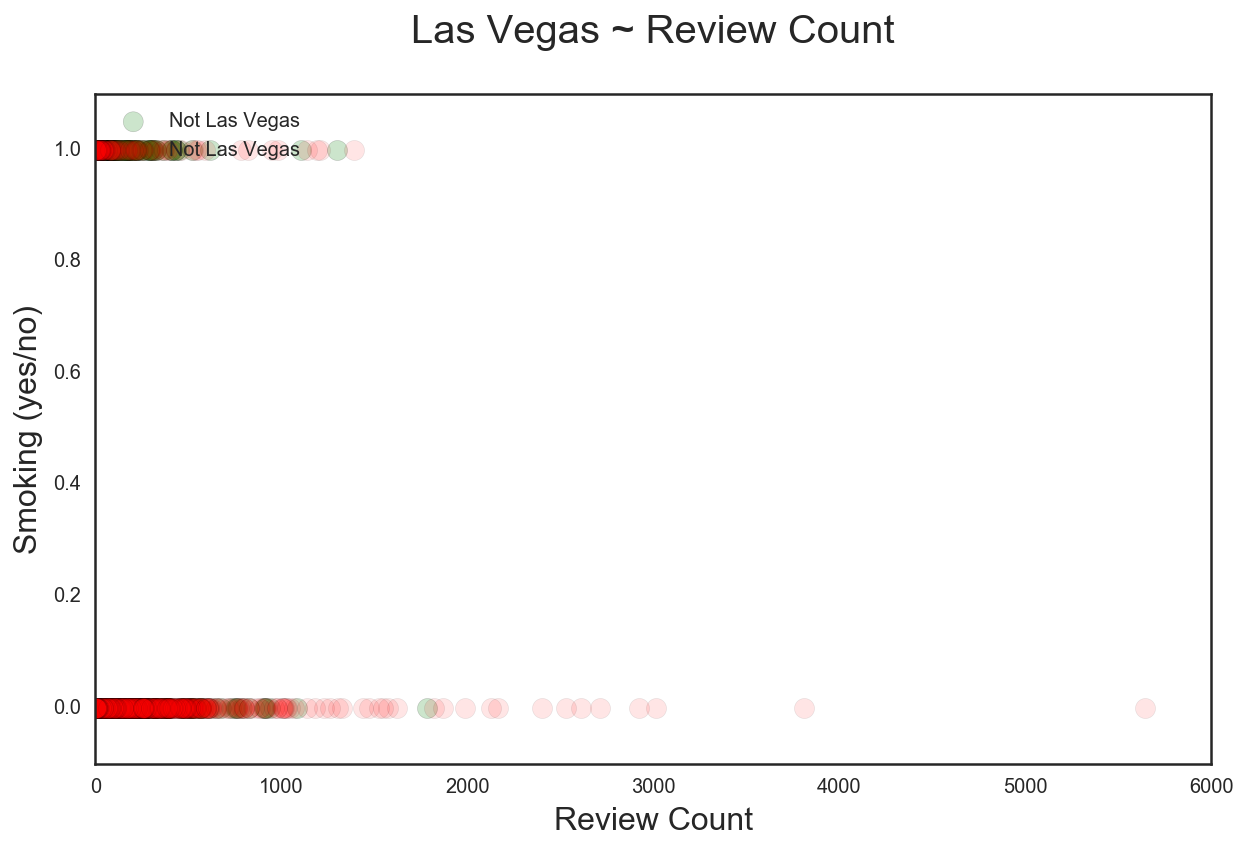

In [284]:
# plot review count and outdoor smoking versus Las Vegas

fig, ax = plt.subplots(figsize=(10,6))

# plot Las Vegas and review counts
x_vals_0 = biz_reviews['review_count'][biz_reviews['las_vegas']==0]
y_vals_0 = biz_reviews['attributes_smoking'][(biz_reviews['las_vegas']==0)].map(lambda x: 1 if x=='outdoor' else 0)

x_vals_1 = biz_reviews['review_count'][biz_reviews['las_vegas']==1]
y_vals_1 = biz_reviews['attributes_smoking'][(biz_reviews['las_vegas']==1)].map(lambda x: 1 if x=='outdoor' else 0)


# do one scatter plot for each type of wine:
ax.scatter(x_vals_0,
           y_vals_0,
           c='g',
           s=100, alpha=0.2,
           label='Not Las Vegas')

ax.scatter(x_vals_1,
           y_vals_1,
           c='r',
           s=100, alpha=0.1,
           label='Not Las Vegas')
# ax.scatter(X['review_count'][X['las_vegas'] == 1],
#            X['las_vegas'][X['las_vegas'] == 1],
#            c=colors['blue'], s=100, alpha=0.7,
#            label='Las Vegas')

# # ax.axvline(xval_chance, lw=3, color=colors['red'], ls='dashed',
# #            label='gpa where P(y = 1) = 0.5')

ax.set_ylabel('Smoking (yes/no)', fontsize=16)
ax.set_xlabel('Review Count', fontsize=16)
ax.set_title('Las Vegas ~ Review Count\n', fontsize=20)

ax.set_xlim([0.,6000.]) ####################### need to set this
ax.set_ylim([-0.1, 1.1])

plt.legend(loc='upper left')
plt.show()

In [ ]:
# plot an ROC curve

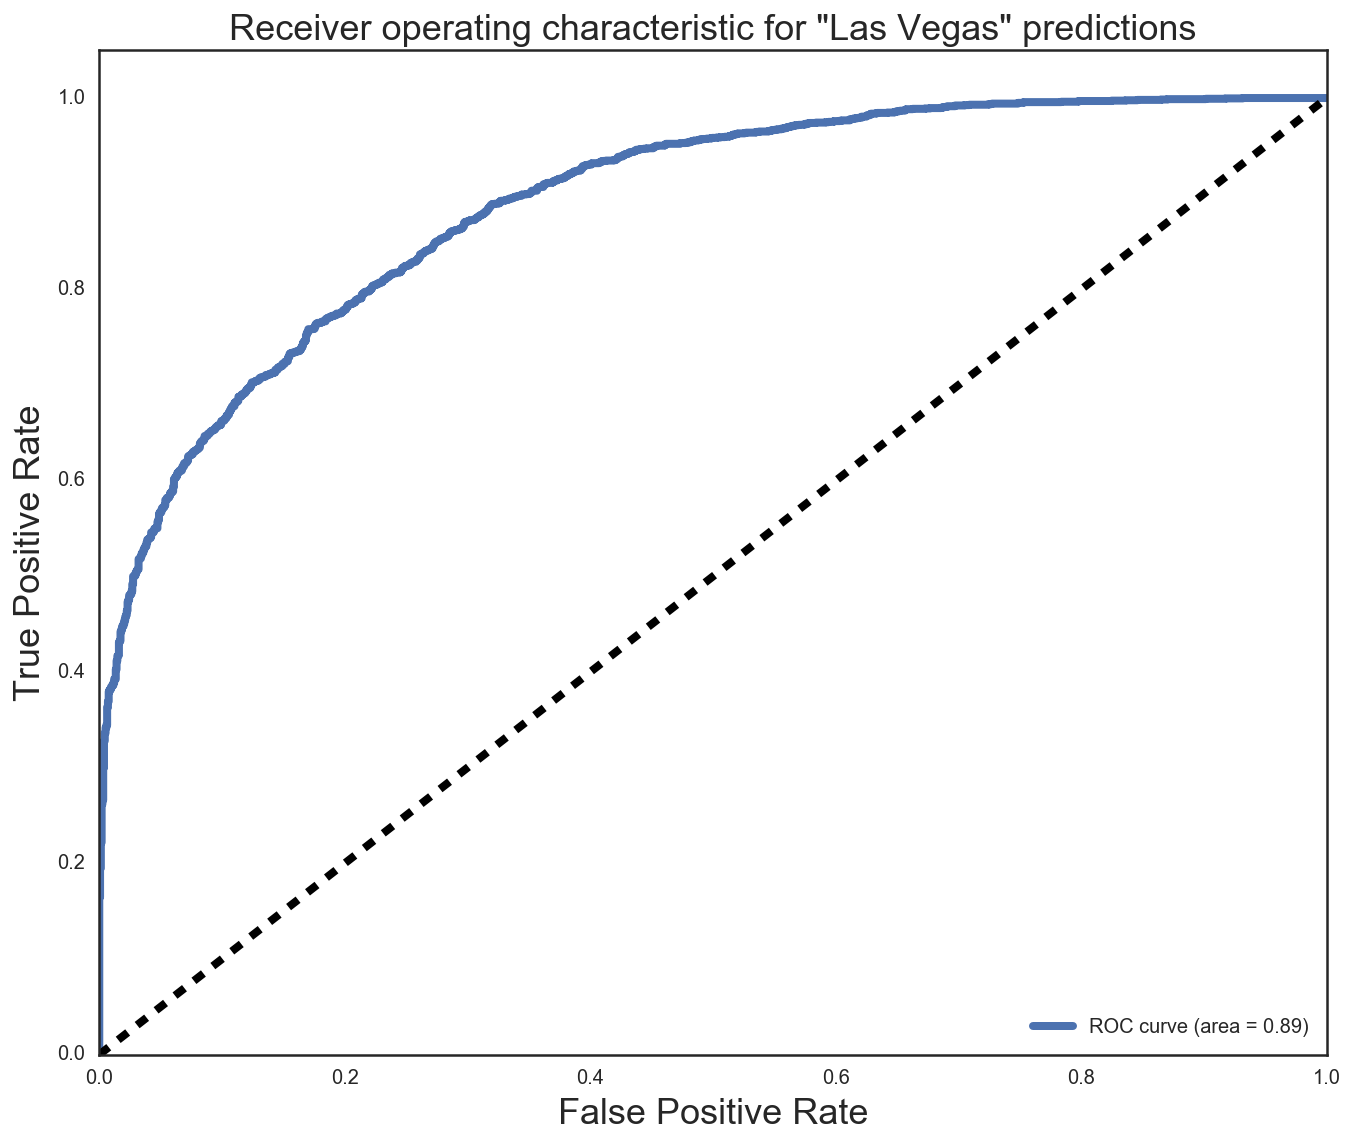

In [286]:

# import roc_curve whcih does X
# import auc which does computes area under the curve 
# if you use roc_auc_score

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

# [insert explanation of this section -- what is this for?  Where do we use this later?]
Y_score = lrcv.decision_function(X)

# [insert explanation of this section -- why do we use these?]
FPR = dict()
TPR = dict()
ROC_AUC = dict()

# [insert explanation of this section]
FPR[1], TPR[1], _ = roc_curve(y, probabilities[:, 1])
ROC_AUC[1] = auc(FPR[1], TPR[1])

# [insert explanation of this section -- what is being plotted?  Which elements are data driven?  Which elements are purely visual?]
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for "Las Vegas" predictions', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Write up a "profile" for Las Vegas. This should be a writeup converting your 
# findings from the model(s) into a human-readable description of the city.
'''OK, this was not the most productive search into the Las Vegas profile.
Here is what I found, here is what was not helpful/here is the problem with
my work, and here is what I would do in my future work.

Here are conclusions:
The feature with the greatest coefficient is "review_count", which makes sense 
compared to the other cities because Las Vegas is a bigger city than the others.
There are more people, so there are more likely to be more reviews! Also the kinds
of people that visit Las Vegas versus Phoenix, Surprise, or Waterloo are going
to be more interested in finding the best kinds of places to do "X".

The feature with the second highest coefficient was attributes_smoking[T.yes], but
there were only 11 businesses with a 'yes', so that is not helpful. Instead, I looked
at the third one, which yielded more businesses.  It seems that there are more
businesses with outdoor smoking, or at least there were more people who cared about
outdoor smoking to click the button on Yelp.

What was not helpful:
I loaded wayyyy too many features.  All the data is muddling up the results. 

For example, a lot of the "important" features were the hours of the business 
operations. I don't think that the hourly information itself is useful, but 
I think it's more that the the data was filled in by yelp users. The users 
cared more to fill that information in, or maybe the businesses themselves filled it in.

What I would do in the future work: 
- Remove the hour data
- Focus on one thing first - maybe the kinds of businesses in Las Vegas versus others,
or the kinds of users that are filling in reviews - how active they are, whether they
are filling in reviews for other cities as well (as they visitors?) There's also
other data including when users checked in, etc.

'''


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Different categories of ratings

---

Yelp is finally ready to admit that their rating system sucks. No one cares about the ratings, they just use the site to find out what's nearby. The ratings are simply too unreliable for people. 

Yelp hypothesizes that this is, in fact, because different people tend to give their ratings based on different things. They believe that perhaps some people always base their ratings on quality of food, others on service, and perhaps other categories as well. 

1. Do some users tend to talk about service more than others in reviews/tips? Divide up the tips/reviews into more "service-focused" ones and those less concerned with service.
2. Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.
3. Construct a regression model for each of the two ratings. They should use the same predictor variables (of your choice). 
4. Validate the performance of the models.
5. Do the models coefficients differ at all? What does this tell you about the hypothesis that there are in fact two different kinds of ratings?

In [288]:
# Split two-word phrases into service and not-service columns.
list(reviews.columns)

# identify two-word phrases with into service-oriented
service_columns = ['customer service', 'food service','friendly staff','good service','great service',
                   'service excellent',  'service food', 'service friendly',  'service good', 
                   'service great',  'staff friendly', 'super friendly']

# sum the numbers from these columns
reviews['sum_service_columns'] = np.sum(reviews.loc[:,service_columns],axis=1)
reviews['sum_service_columns'] = reviews['sum_service_columns'].map(lambda x: 1 if x>0 else 0)

In [289]:
# Same but for tips: Split two-word phrases into service and not-service columns.
list(tips.columns)

# identify two-word phrases with into service-oriented
service_columns = ['awesome service','customer service','excellent service','fast service',
                   'food service','friendly service', 'friendly staff','good service',
                   'great service', 'great staff', 'service food', 'service good',
                   'service great', 'slow service', 'staff friendly', 'staff great',
                   'super friendly',
                  ]

# sum the numbers from these columns
tips['sum_service_columns'] = np.sum(tips.loc[:,service_columns],axis=1)
tips['sum_service_columns'] = tips['sum_service_columns'].map(lambda x: 1 if x>0 else 0)

#### Create two new ratings for businesses: ratings from just the service-focused reviews and ratings from the non-service reviews.

In [290]:
# so I need to identify the ratings from the service reviews

        
# first subset the reviews DF
reviews_service = reviews.loc[:,['user_id', 'business_id', 'sum_service_columns', 'stars','votes.useful']]

In [291]:
# then subset tips DF with service=1
tips_service = tips.loc[:,['user_id','business_id', 'sum_service_columns']]
tips_service = tips_service[tips_service['sum_service_columns'] > 0]

In [292]:
# join the two tables; reviews first and on the left, LEFT join 

reviews_joined = pd.merge(reviews_service, tips_service, how='left', on=['user_id','business_id'])

In [293]:
reviews_joined.head()

,user_id,business_id,sum_service_columns_x,stars,votes.useful,sum_service_columns_y
0,o_LCYay4uo5N4eq3U5pbrQ,EmzaQR5hQlF0WIl24NxAZA,0,3,1,NaN
1,sEWeeq41k4ohBz4jS_iGRw,EmzaQR5hQlF0WIl24NxAZA,0,2,3,NaN
2,1AqEqmmVHgYCuzcMrF4h2g,EmzaQR5hQlF0WIl24NxAZA,0,2,0,NaN
3,pv82zTlB5Txsu2Pusu__FA,EmzaQR5hQlF0WIl24NxAZA,0,2,6,NaN
4,jlr3OBS1_Y3Lqa-H3-FR1g,EmzaQR5hQlF0WIl24NxAZA,0,4,0,NaN


In [294]:
# create one sumservicecolumns which takes the max of both columns. if there
# is any mention of service in either the review or the tips, then it is service
# oriented.
def fillnan(x):
    if x == x:
        return x
    else:
        return 0


reviews_joined['sum_service_columns_y'] = reviews_joined['sum_service_columns_y'].map(fillnan)
reviews_joined.head()

,user_id,business_id,sum_service_columns_x,stars,votes.useful,sum_service_columns_y
0,o_LCYay4uo5N4eq3U5pbrQ,EmzaQR5hQlF0WIl24NxAZA,0,3,1,0.0
1,sEWeeq41k4ohBz4jS_iGRw,EmzaQR5hQlF0WIl24NxAZA,0,2,3,0.0
2,1AqEqmmVHgYCuzcMrF4h2g,EmzaQR5hQlF0WIl24NxAZA,0,2,0,0.0
3,pv82zTlB5Txsu2Pusu__FA,EmzaQR5hQlF0WIl24NxAZA,0,2,6,0.0
4,jlr3OBS1_Y3Lqa-H3-FR1g,EmzaQR5hQlF0WIl24NxAZA,0,4,0,0.0


In [295]:
reviews_joined['service'] = np.maximum(reviews_joined['sum_service_columns_x'],
                                       reviews_joined['sum_service_columns_y'])
reviews_joined.head()

,user_id,business_id,sum_service_columns_x,stars,votes.useful,sum_service_columns_y,service
0,o_LCYay4uo5N4eq3U5pbrQ,EmzaQR5hQlF0WIl24NxAZA,0,3,1,0.0,0.0
1,sEWeeq41k4ohBz4jS_iGRw,EmzaQR5hQlF0WIl24NxAZA,0,2,3,0.0,0.0
2,1AqEqmmVHgYCuzcMrF4h2g,EmzaQR5hQlF0WIl24NxAZA,0,2,0,0.0,0.0
3,pv82zTlB5Txsu2Pusu__FA,EmzaQR5hQlF0WIl24NxAZA,0,2,6,0.0,0.0
4,jlr3OBS1_Y3Lqa-H3-FR1g,EmzaQR5hQlF0WIl24NxAZA,0,4,0,0.0,0.0


In [296]:
reviews_joined.drop(['sum_service_columns_x','sum_service_columns_y'], axis=1, inplace=True)
reviews_joined.head()

,user_id,business_id,stars,votes.useful,service
0,o_LCYay4uo5N4eq3U5pbrQ,EmzaQR5hQlF0WIl24NxAZA,3,1,0.0
1,sEWeeq41k4ohBz4jS_iGRw,EmzaQR5hQlF0WIl24NxAZA,2,3,0.0
2,1AqEqmmVHgYCuzcMrF4h2g,EmzaQR5hQlF0WIl24NxAZA,2,0,0.0
3,pv82zTlB5Txsu2Pusu__FA,EmzaQR5hQlF0WIl24NxAZA,2,6,0.0
4,jlr3OBS1_Y3Lqa-H3-FR1g,EmzaQR5hQlF0WIl24NxAZA,4,0,0.0


In [297]:
reviews_joined.drop('user_id', axis=1, inplace=True)
reviews_joined.head()

,business_id,stars,votes.useful,service
0,EmzaQR5hQlF0WIl24NxAZA,3,1,0.0
1,EmzaQR5hQlF0WIl24NxAZA,2,3,0.0
2,EmzaQR5hQlF0WIl24NxAZA,2,0,0.0
3,EmzaQR5hQlF0WIl24NxAZA,2,6,0.0
4,EmzaQR5hQlF0WIl24NxAZA,4,0,0.0


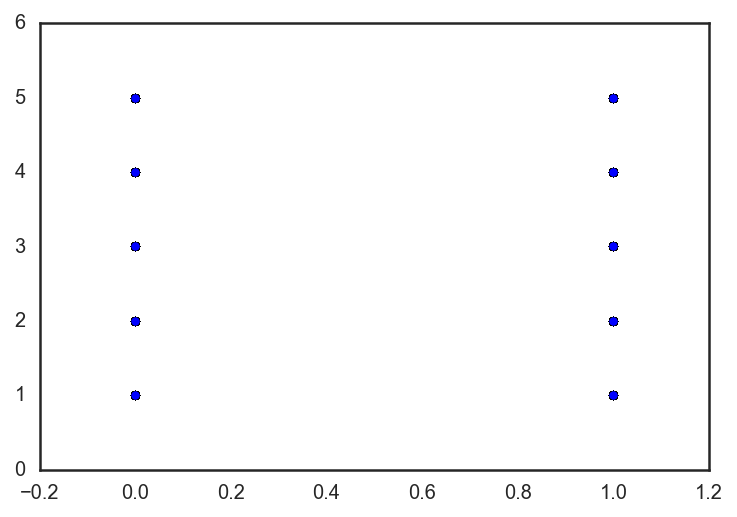

In [298]:
# haha, OK this graph is not helpful.
plt.scatter(reviews_joined['service'],reviews_joined['stars'], alpha = 0.01)

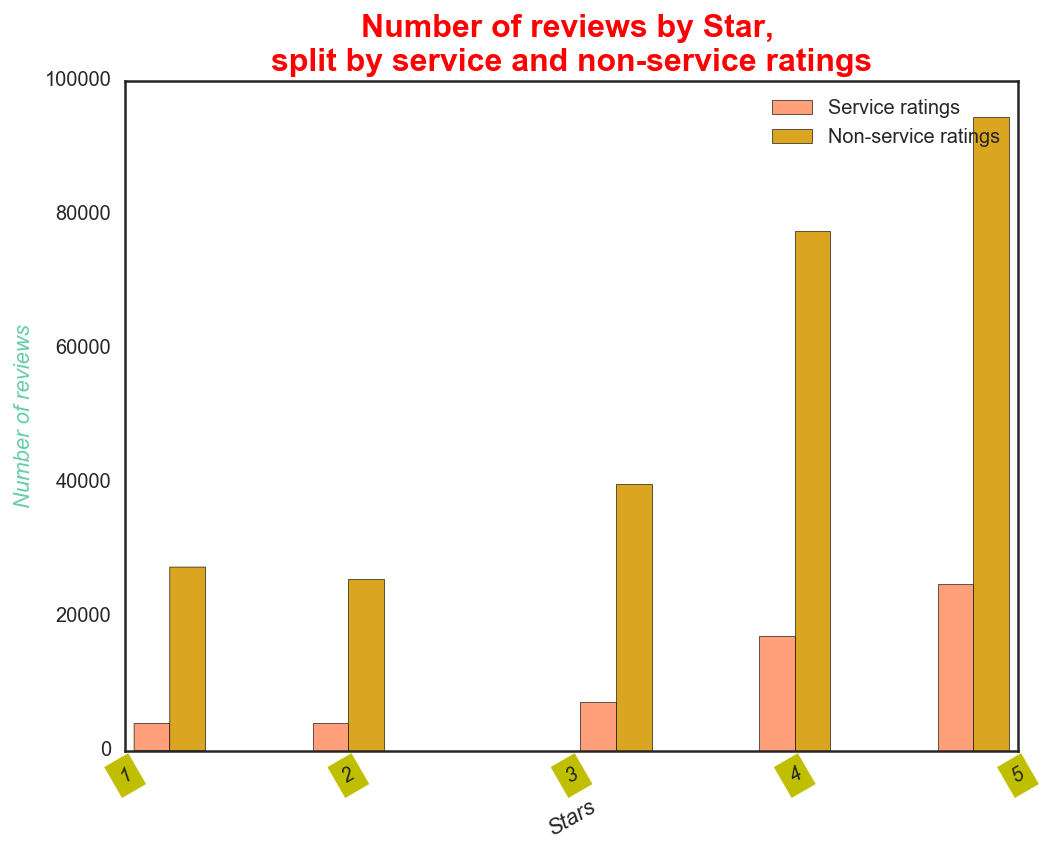

In [299]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.hist([
        reviews_joined['stars'][reviews_joined['service'] == 1],
        reviews_joined['stars'][reviews_joined['service'] == 0]
        ], 
        color=['lightsalmon','goldenrod'], stacked=False, 
        label=['Service ratings','Non-service ratings'])

ax.set_xlabel('Stars', style='italic', rotation=30)
ax.set_ylabel('Number of reviews', style='italic', rotation=90, color='mediumaquamarine')
ax.set_title('Number of reviews by Star, \nsplit by service and non-service ratings', 
             fontsize=16, weight='bold', color='r')
ax.legend()
ax.set_xticklabels(['1','','2','','3','','4','','5'],rotation=30, style='oblique', 
                   animated=True, backgroundcolor='y', verticalalignment='top')

In [300]:
reviews_gb = reviews_joined.groupby(['business_id','service']).mean()
reviews_gb.reset_index(inplace=True)
reviews_gb.shape

(7455, 4)

In [301]:
avg_stars_per_biz = reviews_gb.groupby(['business_id', 'service']).mean()
avg_stars_per_biz.reset_index(inplace=True)
avg_stars_per_biz.head()

,business_id,service,stars,votes.useful
0,--jFTZmywe7StuZ2hEjxyA,0.0,4.000000,0.50
1,--jFTZmywe7StuZ2hEjxyA,1.0,3.000000,4.00
2,-0HGqwlfw3I8nkJyMHxAsQ,0.0,2.857143,0.00
3,-0HGqwlfw3I8nkJyMHxAsQ,1.0,3.500000,0.50
4,-0VK5Z1BfUHUYq4PoBYNLw,0.0,3.750000,0.25


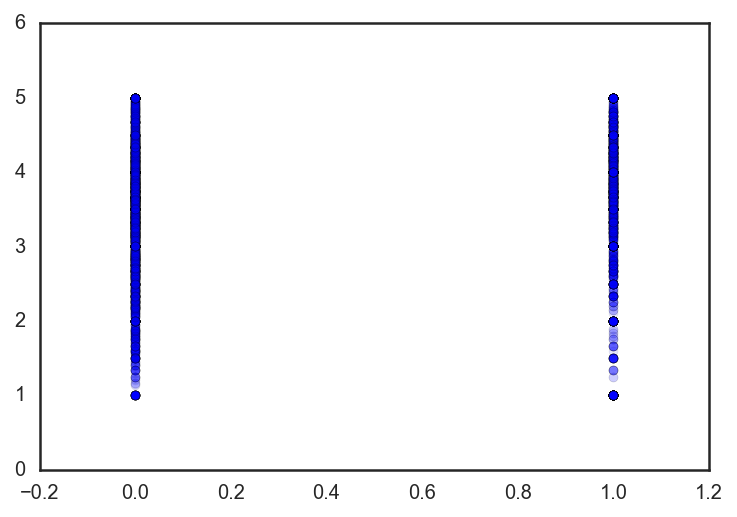

In [302]:
# avg per biz
plt.scatter(avg_stars_per_biz['service'],avg_stars_per_biz['stars'], alpha = 0.1)

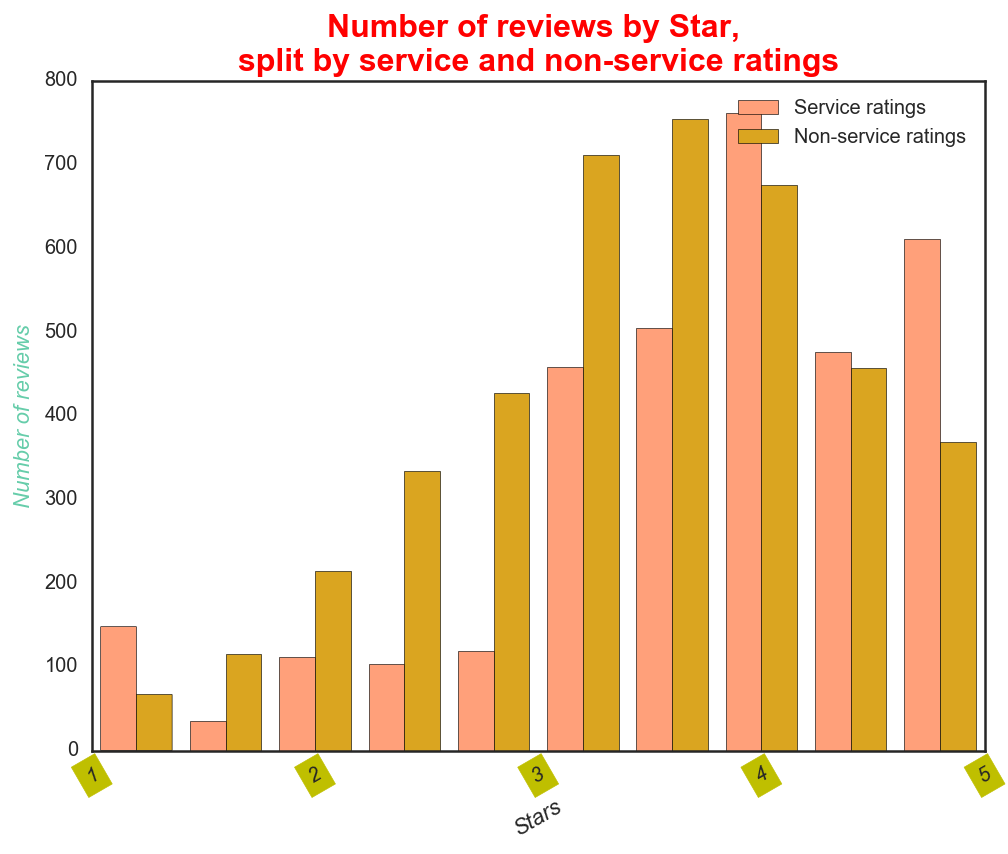

In [303]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
ax.hist([
        avg_stars_per_biz['stars'][avg_stars_per_biz['service'] == 1],
        avg_stars_per_biz['stars'][avg_stars_per_biz['service'] == 0],
        ], 
        color=['lightsalmon','goldenrod'], stacked=False, 
        label=['Service ratings','Non-service ratings'])

ax.set_xlabel('Stars', style='italic', rotation=30)
ax.set_ylabel('Number of reviews', style='italic', rotation=90, color='mediumaquamarine')
ax.set_title('Number of reviews by Star, \nsplit by service and non-service ratings', 
             fontsize=16, weight='bold', color='r')
ax.legend()
ax.set_xticklabels(['1','','2','','3','','4','','5'],rotation=30, style='oblique', 
                   animated=True, backgroundcolor='y', verticalalignment='top')

#### 3. Set up a regression

In [304]:
# huh, that looks like a pattern. I wonder if I could find a relationship
# between service/non-service ratings AND whether ratings are 4 or more stars?

In [305]:
# set up a regression
y = avg_stars_per_biz['stars'].map(lambda x: 1 if x>=4 else 0)

X = avg_stars_per_biz[['service','votes.useful']]

ss = StandardScaler()
X_norm = ss.fit_transform(X)

# initialize and fit model
lrcv = LogisticRegressionCV(Cs=[0.1, 0.5, 1], cv=4)
model = lrcv.fit(X_norm, y)


In [306]:
print model.coef_, '\n'
print model.score(X_norm, y), '\n'
print model.scores_, '\n'
probabilities = model.predict_proba(X_norm)
print probabilities
predictions = model.predict(X_norm)

[[ 0.43078364  0.05729083]] 

0.609255533199 

{1: array([[ 0.6110515 ,  0.61266094,  0.61266094],
       [ 0.61373391,  0.61319742,  0.61319742],
       [ 0.60354077,  0.60085837,  0.60139485],
       [ 0.60923242,  0.60869565,  0.60815888]])} 

[[ 0.71035046  0.28964954]
 [ 0.46078847  0.53921153]
 [ 0.71583694  0.28416306]
 ..., 
 [ 0.50093396  0.49906604]
 [ 0.70673872  0.29326128]
 [ 0.51433875  0.48566125]]


In [307]:
from sklearn.metrics import classification_report

creport = classification_report(y, predictions)
print creport

df_confusion = pd.crosstab(y, predictions, rownames=['Actual'], 
                           colnames=['Predicted'], margins=True)

print df_confusion


             precision    recall  f1-score   support

          0       0.63      0.88      0.73      4572
          1       0.49      0.18      0.26      2883

avg / total       0.57      0.61      0.55      7455

Predicted     0     1   All
Actual                     
0          4031   541  4572
1          2372   511  2883
All        6403  1052  7455


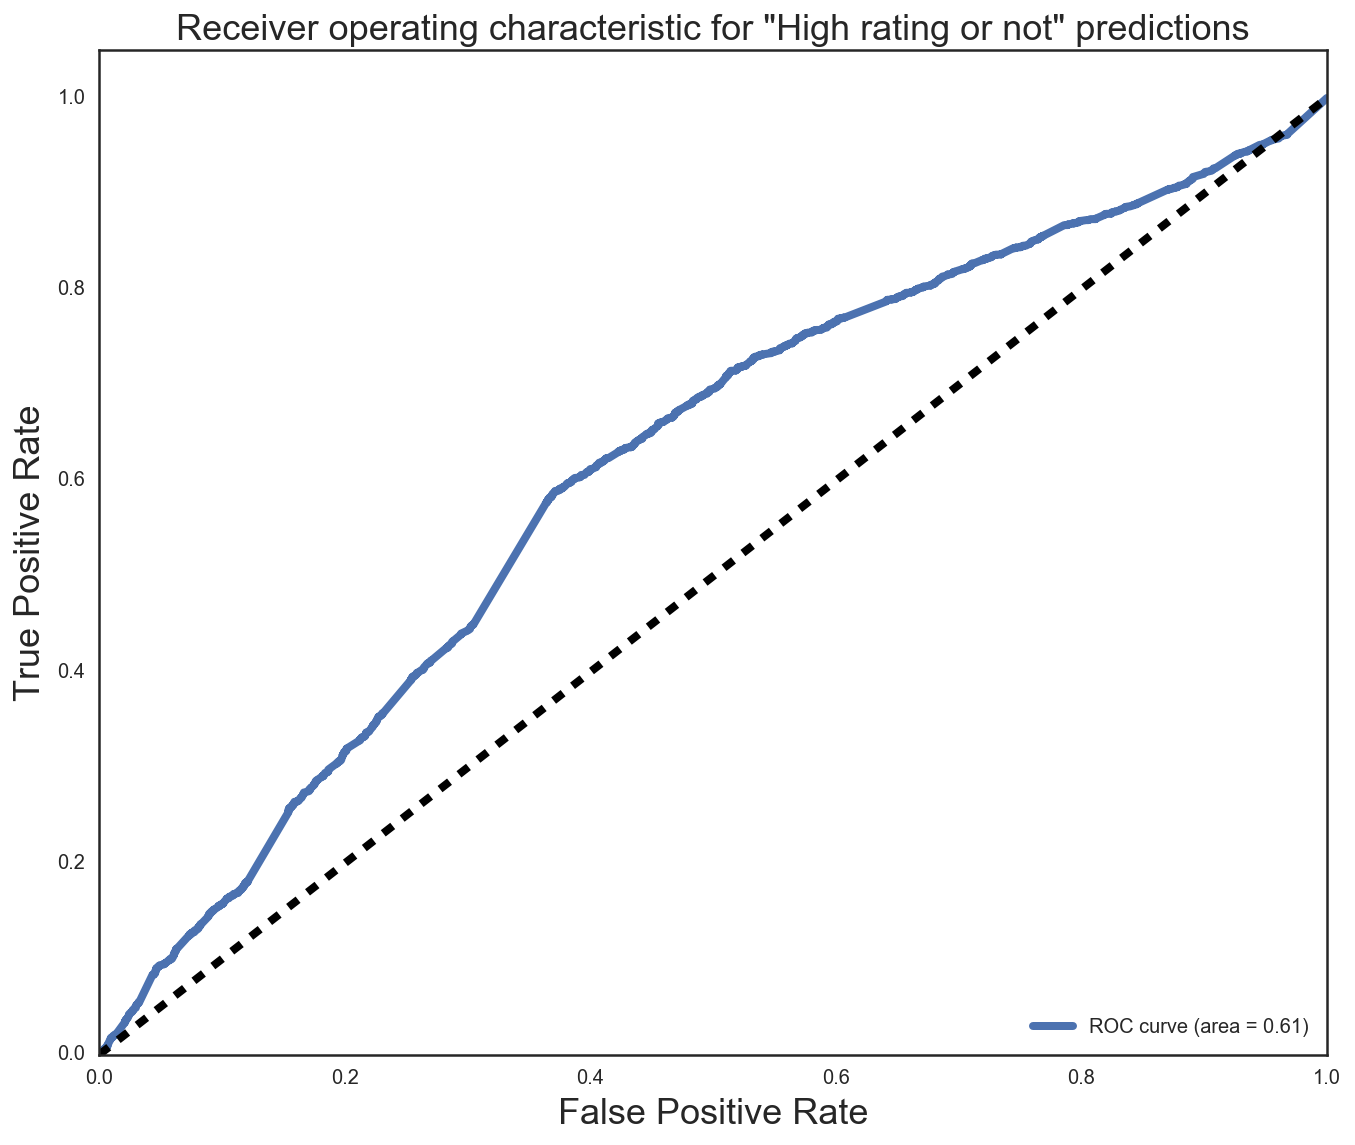

In [308]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

# [insert explanation of this section -- what is this for?  Where do we use this later?]
Y_score = model.decision_function(X)

# [insert explanation of this section -- why do we use these?]
FPR = dict()
TPR = dict()
ROC_AUC = dict()

# [insert explanation of this section]
FPR[1], TPR[1], _ = roc_curve(y, probabilities[:, 1])
ROC_AUC[1] = auc(FPR[1], TPR[1])

# [insert explanation of this section -- what is being plotted?  Which elements are data driven?  Which elements are purely visual?]
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for "High rating or not" predictions', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Conclusion:
'''Accuracy of this model is not fantastic, at .60 ish. On top of that,
precision for '1' is not fantastic (precision is TP/(TP+FP) - of the ones I said
were higher ratings, how often was I right? Same with recall, which is TP/(TP + FN), 
which means of the ones that were ACTUALLY a high rating, which ones did I get right.
I got only 18% of those correct> They are not fantastic numbers.  The ROC curve doesnt
look fantastic either.

I chose to use 'service' and also 'votes useful' as my predictors.  It turns out that
whether a business has any service oriented reviews seems related to its overall
average rating. ie. whether a business has service-oriented reviews, at a coefficient
of 0.43, seems to make a difference in whether the rating is high (4 or above) or not.


'''


In [309]:
corrs = X.corr()

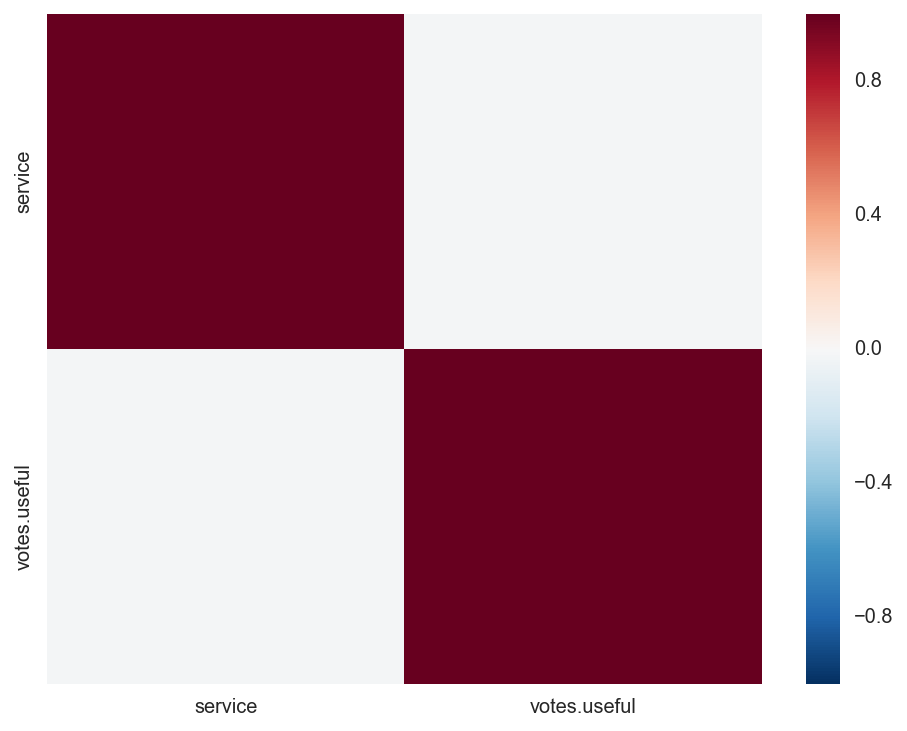

In [310]:
fig = plt.figure(figsize=(8,6))
ax = sns.heatmap(corrs)

# conclusion here - the two variables are not highly correlated, whew.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. Identifying "elite" users

---

Yelp, though having their own formula for determining whether a user is elite or not, is interested in delving deeper into what differentiates an elite user from a normal user at a broader level.

Use a classification model to predict whether a user is elite or not. Note that users can be elite in some years and not in others.

1. What things predict well whether a user is elite or not?
- Validate the model.
- If you were to remove the "counts" metrics for users (reviews, votes, compliments), what distinguishes an elite user, if anything? Validate the model and compare it to the one with the count variables.
- Think of a way to visually represent your results in a compelling way.
- Give a brief write-up of your findings.


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 4. Find something interesting on your own

---

You want to impress your superiors at Yelp by doing some investigation into the data on your own. You want to do classification, but you're not sure on what.

1. Create a hypothesis or hypotheses about the data based on whatever you are interested in, as long as it is predicting a category of some kind (classification).
2. Explore the data visually (ideally related to this hypothesis).
3. Build one or more classification models to predict your target variable. **Your modeling should include gridsearching to find optimal model parameters.**
4. Evaluate the performance of your model. Explain why your model may have chosen those specific parameters during the gridsearch process.
5. Write up what the model tells you. Does it validate or invalidate your hypothesis? Write this up as if for a non-technical audience.

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 5. ROC and Precision-recall

---

Some categories have fewer overall businesses than others. Choose two categories of businesses to predict, one that makes your proportion of target classes as even as possible, and another that has very few businesses and thus makes the target varible imbalanced.

1. Create two classification models predicting these categories. Optimize the models and choose variables as you see fit.
- Make confusion matrices for your models. Describe the confusion matrices and explain what they tell you about your models' performance.
- Make ROC curves for both models. What do the ROC curves describe and what do they tell you about your model?
- Make Precision-Recall curves for the models. What do they describe? How do they compare to the ROC curves?
- Explain when Precision-Recall may be preferable to ROC. Is that the case in either of your models?